In [2]:
# ✅ CELL 1: Mount Google Drive and Setup Environment
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import glob

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create save directories in Drive
SAVE_DIR = '/content/drive/MyDrive/Pix2Pix_Lab6'
CHECKPOINT_DIR = f'{SAVE_DIR}/checkpoints'
RESULTS_DIR = f'{SAVE_DIR}/results'
DATA_DIR = f'{SAVE_DIR}/data'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

print(f"Save directory: {SAVE_DIR}")

Mounted at /content/drive
Using device: cpu
Save directory: /content/drive/MyDrive/Pix2Pix_Lab6


In [8]:
!unzip "/content/drive/MyDrive/Edge2shoes/archive.zip" -d "/content/drive/MyDrive/Edge2shoes/"

unzip:  cannot find or open /content/drive/MyDrive/Edge2shoes/archive.zip, /content/drive/MyDrive/Edge2shoes/archive.zip.zip or /content/drive/MyDrive/Edge2shoes/archive.zip.ZIP.


In [9]:
# ✅ CELL 2: Dataset Setup (Already Extracted)
import os
import glob

# Dataset is already extracted here:
DATASET_BASE = "/content/drive/MyDrive/Edge2shoes"
EXTRACTED_DIR = f"{DATASET_BASE}/archive"  # or just DATASET_BASE depending on structure

print("Using pre-extracted dataset...")
print(f"Dataset location: {DATASET_BASE}")

# Check what was extracted
!ls -la "{DATASET_BASE}"
print("\n--- Contents of archive folder ---")
!ls -la "{DATASET_BASE}/archive" 2>/dev/null || echo "No archive subfolder"

# Find the actual image folder
# Usually it's: /content/drive/MyDrive/Edge2shoes/archive/edges2shoes/ or similar
possible_paths = [
    f"{DATASET_BASE}/edges2shoes",
    f"{DATASET_BASE}/archive/edges2shoes",
    f"{DATASET_BASE}/archive",
    DATASET_BASE
]

DATA_PATH = None
for path in possible_paths:
    if os.path.exists(path):
        # Check if it contains jpg files
        jpg_files = glob.glob(f"{path}/*.jpg") or glob.glob(f"{path}/**/*.jpg", recursive=True)
        if len(jpg_files) > 0:
            DATA_PATH = path if len(glob.glob(f"{path}/*.jpg")) > 0 else os.path.dirname(jpg_files[0])
            print(f"\n✅ Found dataset at: {DATA_PATH}")
            print(f"   Sample files: {jpg_files[:3]}")
            break

if DATA_PATH is None:
    print("❌ Could not find dataset. Please check the extracted structure.")
    # List all files recursively to debug
    !find "{DATASET_BASE}" -name "*.jpg" | head -5
else:
    print(f"\nDataset ready at: {DATA_PATH}")



Using pre-extracted dataset...
Dataset location: /content/drive/MyDrive/Edge2shoes
total 2134779
drwx------ 4 root root       4096 Feb 26 03:19 'archive (2) (Unzipped Files)'
-rw------- 1 root root 2186000561 Feb 26 02:57 'archive (2).zip'
drwx------ 2 root root       4096 Oct 18  2020  train
drwx------ 2 root root       4096 Oct 18  2020  val

--- Contents of archive folder ---
No archive subfolder

✅ Found dataset at: /content/drive/MyDrive/Edge2shoes/train
   Sample files: ['/content/drive/MyDrive/Edge2shoes/train/10001_AB.jpg', '/content/drive/MyDrive/Edge2shoes/train/10000_AB.jpg', '/content/drive/MyDrive/Edge2shoes/train/10002_AB.jpg']

Dataset ready at: /content/drive/MyDrive/Edge2shoes/train


In [10]:
# ✅ CELL 3: Custom Dataset Class for Paired Images
class Edges2ShoesDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

        # Get all jpg files
        self.files = sorted(glob.glob(os.path.join(root_dir, '*.jpg')))

        if len(self.files) == 0:
            # Try recursive search
            self.files = sorted(glob.glob(os.path.join(root_dir, '**/*.jpg'), recursive=True))

        print(f"Found {len(self.files)} total images in {root_dir}")

        if len(self.files) == 0:
            raise ValueError(f"No images found in {root_dir}! Check the path.")

        # Split: 90% train, 10% test
        split_idx = int(len(self.files) * 0.9)
        if mode == 'train':
            self.files = self.files[:split_idx]
        else:
            self.files = self.files[split_idx:]

        print(f"{mode} set: {len(self.files)} images")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)

        # Edges2Shoes: 512x256 (left=edge, right=real) or 256x512 (top=edge, bottom=real)
        h, w = img.shape[:2]

        # Check orientation (usually width is 512, height is 256)
        if w > h:  # Horizontal concatenation (left-right)
            mid = w // 2
            edge_img = img[:, :mid, :]
            real_img = img[:, mid:, :]
        else:  # Vertical concatenation (top-bottom)
            mid = h // 2
            edge_img = img[:mid, :, :]
            real_img = img[mid:, :, :]

        # Convert to PIL for transforms
        edge_img = Image.fromarray(edge_img)
        real_img = Image.fromarray(real_img)

        if self.transform:
            edge_img = self.transform(edge_img)
            real_img = self.transform(real_img)

        return {'A': edge_img, 'B': real_img, 'path': img_path}

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Use the detected path from Cell 2
try:
    dataset_path = DATA_PATH  # From Cell 2
except NameError:
    # Fallback if running cell independently
    dataset_path = "/content/drive/MyDrive/Edge2shoes/archive/edges2shoes"
    if not os.path.exists(dataset_path):
        dataset_path = "/content/drive/MyDrive/Edge2shoes/archive"

print(f"\nUsing dataset path: {dataset_path}")

# Create datasets
train_dataset = Edges2ShoesDataset(dataset_path, transform=transform, mode='train')
test_dataset = Edges2ShoesDataset(dataset_path, transform=transform, mode='test')

# Create dataloaders
BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nTrain batches: {len(train_loader)}, Test batches: {len(test_loader)}")



Using dataset path: /content/drive/MyDrive/Edge2shoes/train
Found 7 total images in /content/drive/MyDrive/Edge2shoes/train
train set: 6 images
Found 7 total images in /content/drive/MyDrive/Edge2shoes/train
test set: 1 images

Train batches: 2, Test batches: 1


Saved to /content/drive/MyDrive/Pix2Pix_Lab6/results/sample_data.png


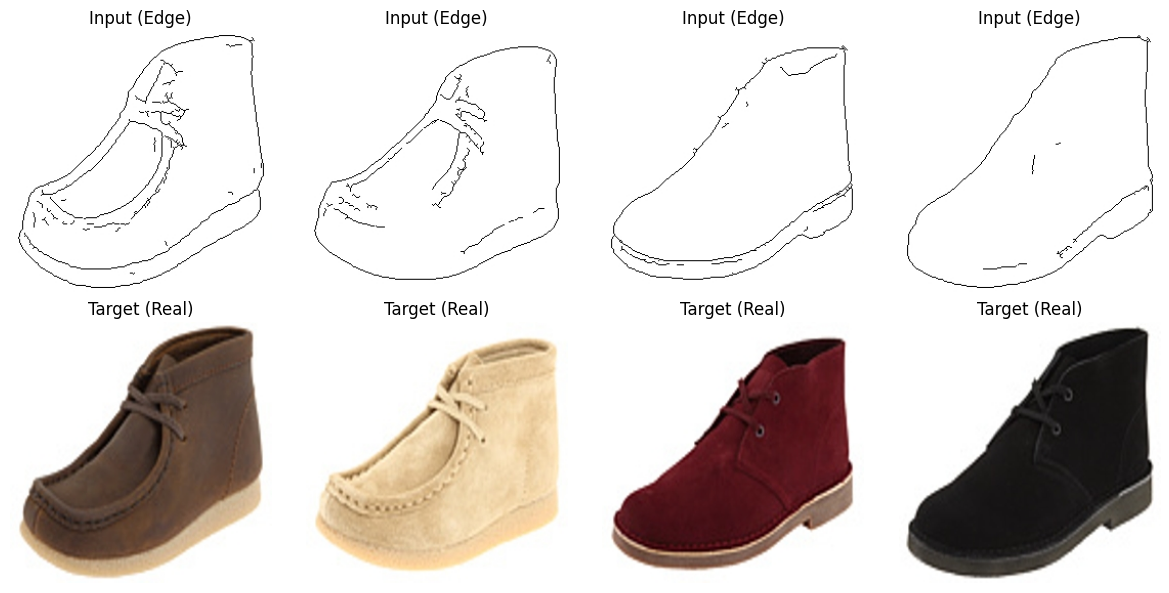

In [11]:
# ✅ CELL 4: Visualize Sample Data
def denormalize(tensor):
    """Convert from [-1, 1] to [0, 1]"""
    return (tensor + 1) / 2

def visualize_batch(batch, num_samples=4, save_path=None):
    """Visualize edge-to-shoe pairs"""
    edges = batch['A'][:num_samples]
    reals = batch['B'][:num_samples]

    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*3, 6))

    for i in range(num_samples):
        # Edge image
        edge = denormalize(edges[i]).permute(1, 2, 0).cpu().numpy()
        axes[0, i].imshow(np.clip(edge, 0, 1))
        axes[0, i].set_title('Input (Edge)')
        axes[0, i].axis('off')

        # Real image
        real = denormalize(reals[i]).permute(1, 2, 0).cpu().numpy()
        axes[1, i].imshow(np.clip(real, 0, 1))
        axes[1, i].set_title('Target (Real)')
        axes[1, i].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved to {save_path}")
    plt.show()

# Get a sample batch
sample_batch = next(iter(train_loader))
visualize_batch(sample_batch, save_path=f"{RESULTS_DIR}/sample_data.png")

In [12]:
# ✅ CELL 5: U-Net Generator Implementation
class UNetDown(nn.Module):
    """U-Net downsampling block"""
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    """U-Net upsampling block with skip connections"""
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)  # Skip connection
        return x

class UNetGenerator(nn.Module):
    """U-Net Generator for Pix2Pix"""
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        # Encoder (Downsampling)
        self.down1 = UNetDown(in_channels, 64, normalize=False)          # 128x128
        self.down2 = UNetDown(64, 128)                                    # 64x64
        self.down3 = UNetDown(128, 256)                                   # 32x32
        self.down4 = UNetDown(256, 512, dropout=0.5)                      # 16x16
        self.down5 = UNetDown(512, 512, dropout=0.5)                      # 8x8
        self.down6 = UNetDown(512, 512, dropout=0.5)                      # 4x4
        self.down7 = UNetDown(512, 512, dropout=0.5)                      # 2x2
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)     # 1x1 (bottleneck)

        # Decoder (Upsampling) with skip connections
        self.up1 = UNetUp(512, 512, dropout=0.5)          # +512 = 1024
        self.up2 = UNetUp(1024, 512, dropout=0.5)         # +512 = 1024
        self.up3 = UNetUp(1024, 512, dropout=0.5)         # +512 = 1024
        self.up4 = UNetUp(1024, 512, dropout=0.5)         # +512 = 1024
        self.up5 = UNetUp(1024, 256)                      # +256 = 512
        self.up6 = UNetUp(512, 128)                       # +128 = 256
        self.up7 = UNetUp(256, 64)                        # +64 = 128

        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        # Decoder with skip connections
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final_up(u7)

# Test generator
test_gen = UNetGenerator().to(device)
test_input = torch.randn(1, 3, 256, 256).to(device)
test_output = test_gen(test_input)
print(f"Generator input shape: {test_input.shape}")
print(f"Generator output shape: {test_output.shape}")
print(f"Generator parameters: {sum(p.numel() for p in test_gen.parameters()):,}")


Generator input shape: torch.Size([1, 3, 256, 256])
Generator output shape: torch.Size([1, 3, 256, 256])
Generator parameters: 54,404,099


In [13]:
# ✅ CELL 6: PatchGAN Discriminator Implementation
class PatchGANDiscriminator(nn.Module):
    """PatchGAN Discriminator - outputs patch-wise real/fake"""
    def __init__(self, in_channels=6):  # 6 = 3 (input) + 3 (target/generated)
        super().__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),  # 128x128
            *discriminator_block(64, 128),                           # 64x64
            *discriminator_block(128, 256),                          # 32x32
            *discriminator_block(256, 512),                          # 16x16
            nn.Conv2d(512, 1, 4, padding=1)                          # 15x15 patch output
        )

    def forward(self, img_A, img_B):
        # Concatenate input and target/generated image
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

# Test discriminator
test_disc = PatchGANDiscriminator().to(device)
test_real = torch.randn(1, 3, 256, 256).to(device)
test_fake = torch.randn(1, 3, 256, 256).to(device)
disc_output = test_disc(test_real, test_fake)
print(f"Discriminator input shapes: {test_real.shape}, {test_fake.shape}")
print(f"Discriminator output shape: {disc_output.shape} (Patch output!)")
print(f"Discriminator parameters: {sum(p.numel() for p in test_disc.parameters()):,}")

Discriminator input shapes: torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256])
Discriminator output shape: torch.Size([1, 1, 15, 15]) (Patch output!)
Discriminator parameters: 2,767,809


In [14]:
# ✅ CELL 7: Baseline CNN Encoder-Decoder (For Comparison)
class BaselineEncoderDecoder(nn.Module):
    """Simple CNN Encoder-Decoder WITHOUT skip connections"""
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # Decoder (NO skip connections)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Test baseline
test_baseline = BaselineEncoderDecoder().to(device)
baseline_output = test_baseline(test_input)
print(f"Baseline output shape: {baseline_output.shape}")
print(f"Baseline parameters: {sum(p.numel() for p in test_baseline.parameters()):,}")


Baseline output shape: torch.Size([1, 3, 256, 256])
Baseline parameters: 5,515,267


In [15]:
# ✅ CELL 8: Loss Functions and Training Setup
# Loss functions
criterion_GAN = nn.MSELoss()  # Adversarial loss (LSGAN)
criterion_L1 = nn.L1Loss()    # Reconstruction loss

# Hyperparameters
LR = 0.0002
BETA1 = 0.5
BETA2 = 0.999
LAMBDA_L1 = 100  # Weight for L1 loss
NUM_EPOCHS = 50

# Initialize models
generator = UNetGenerator().to(device)
discriminator = PatchGANDiscriminator().to(device)
baseline = BaselineEncoderDecoder().to(device)

# Optimizers
opt_G = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, BETA2))
opt_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, BETA2))
opt_Baseline = optim.Adam(baseline.parameters(), lr=LR, betas=(BETA1, BETA2))

# Learning rate schedulers
scheduler_G = optim.lr_scheduler.LambdaLR(opt_G, lambda epoch: 1.0 - max(0, epoch - 100) / 100)
scheduler_D = optim.lr_scheduler.LambdaLR(opt_D, lambda epoch: 1.0 - max(0, epoch - 100) / 100)

print("Models initialized!")
print(f"Generator params: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator params: {sum(p.numel() for p in discriminator.parameters()):,}")
print(f"Baseline params: {sum(p.numel() for p in baseline.parameters()):,}")


Models initialized!
Generator params: 54,404,099
Discriminator params: 2,767,809
Baseline params: 5,515,267


In [16]:

# ✅ CELL 9: Training Functions
def train_pix2pix(generator, discriminator, train_loader, opt_G, opt_D, epoch):
    """Train Pix2Pix for one epoch"""
    generator.train()
    discriminator.train()

    total_G_loss = 0
    total_D_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")

    for batch in pbar:
        real_A = batch['A'].to(device)  # Input (edges)
        real_B = batch['B'].to(device)  # Target (real shoes)

        # Ground truths for discriminator (PatchGAN)
        valid = torch.ones((real_A.size(0), 1, 15, 15), device=device)
        fake = torch.zeros((real_A.size(0), 1, 15, 15), device=device)

        # ====================
        # Train Generator
        # ====================
        opt_G.zero_grad()

        # Generate fake image
        fake_B = generator(real_A)

        # GAN loss (how well does it fool discriminator)
        pred_fake = discriminator(real_A, fake_B)
        loss_GAN = criterion_GAN(pred_fake, valid)

        # L1 reconstruction loss
        loss_L1 = criterion_L1(fake_B, real_B)

        # Total generator loss
        loss_G = loss_GAN + LAMBDA_L1 * loss_L1

        loss_G.backward()
        opt_G.step()

        # ====================
        # Train Discriminator
        # ====================
        opt_D.zero_grad()

        # Real images
        pred_real = discriminator(real_A, real_B)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake images (detach to avoid training G on D's step)
        pred_fake = discriminator(real_A, fake_B.detach())
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total discriminator loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        opt_D.step()

        total_G_loss += loss_G.item()
        total_D_loss += loss_D.item()

        pbar.set_postfix({
            'G_loss': f'{loss_G.item():.4f}',
            'D_loss': f'{loss_D.item():.4f}',
            'L1': f'{loss_L1.item():.4f}'
        })

    return total_G_loss / len(train_loader), total_D_loss / len(train_loader)

def train_baseline(baseline, train_loader, optimizer, epoch):
    """Train baseline CNN (simple L1 loss)"""
    baseline.train()
    total_loss = 0

    pbar = tqdm(train_loader, desc=f"Baseline Epoch {epoch}")

    for batch in pbar:
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        optimizer.zero_grad()

        fake_B = baseline(real_A)
        loss = criterion_L1(fake_B, real_B)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'L1': f'{loss.item():.4f}'})

    return total_loss / len(train_loader)

In [22]:
# ✅ CELL 10: Visualization and Saving Functions
def save_checkpoint(models, optimizers, epoch, save_dir):
    """Save model checkpoints"""
    checkpoint = {
        'epoch': epoch,
        'generator': models['G'].state_dict(),
        'discriminator': models['D'].state_dict(),
        'baseline': models['B'].state_dict(),
        'opt_G': optimizers['G'].state_dict(),
        'opt_D': optimizers['D'].state_dict(),
        'opt_B': optimizers['B'].state_dict(),
    }
    path = f"{save_dir}/checkpoint_epoch_{epoch}.pth"
    torch.save(checkpoint, path)
    print(f"Checkpoint saved: {path}")

def generate_samples(generator, baseline, test_loader, epoch, save_dir, num_samples=4):
    """Generate and save comparison images"""
    generator.eval()
    baseline.eval()

    with torch.no_grad():
        batch = next(iter(test_loader))
        real_A = batch['A'][:num_samples].to(device)
        real_B = batch['B'][:num_samples].to(device)

        fake_B_pix2pix = generator(real_A)
        fake_B_baseline = baseline(real_A)

        # Create figure
        fig, axes = plt.subplots(4, num_samples, figsize=(num_samples*3, 12))

        # Ensure axes is always a 2D array, even if num_samples is 1
        if num_samples == 1:
            axes = axes.reshape(-1, 1) # Reshape to (4, 1)

        for i in range(num_samples):
            # Input
            img_A = denormalize(real_A[i]).permute(1, 2, 0).cpu().numpy()
            axes[0, i].imshow(np.clip(img_A, 0, 1))
            axes[0, i].set_title('Input (Edge)')
            axes[0, i].axis('off')

            # Pix2Pix Output
            img_pix2pix = denormalize(fake_B_pix2pix[i]).permute(1, 2, 0).cpu().numpy()
            axes[1, i].imshow(np.clip(img_pix2pix, 0, 1))
            axes[1, i].set_title('Pix2Pix (GAN)')
            axes[1, i].axis('off')

            # Baseline Output
            img_baseline = denormalize(fake_B_baseline[i]).permute(1, 2, 0).cpu().numpy()
            axes[2, i].imshow(np.clip(img_baseline, 0, 1))
            axes[2, i].set_title('Baseline CNN')
            axes[2, i].axis('off')

            # Ground Truth
            img_real = denormalize(real_B[i]).permute(1, 2, 0).cpu().numpy()
            axes[3, i].imshow(np.clip(img_real, 0, 1))
            axes[3, i].set_title('Ground Truth')
            axes[3, i].axis('off')

        plt.tight_layout()
        save_path = f"{save_dir}/comparison_epoch_{epoch}.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved comparison to {save_path}")
        plt.show()

        return save_path

def plot_training_history(history, save_dir):
    """Plot and save training curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    axes[0].plot(history['G_loss'], label='Generator Loss', color='blue')
    axes[0].plot(history['D_loss'], label='Discriminator Loss', color='red')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Pix2Pix Training Losses')
    axes[0].legend()
    axes[0].grid(True)

    # Baseline loss
    axes[1].plot(history['B_loss'], label='Baseline L1 Loss', color='green')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Baseline CNN Training Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    save_path = f"{save_dir}/training_history.png"
    plt.savefig(save_path, dpi=150)
    print(f"Saved training history to {save_path}")
    plt.show()

In [23]:
def generate_samples(generator, baseline, test_loader, epoch, save_dir, num_samples=1):
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    generator.eval()
    baseline.eval()

    with torch.no_grad():
        data = next(iter(test_loader))
        real_A = data['A'].to(device)
        real_B = data['B'].to(device)

        fake_B = generator(real_A)
        baseline_B = baseline(real_A)

        # Ensure num_samples does not exceed batch size
        num_samples = min(num_samples, real_A.size(0))

        # Create subplot grid
        fig, axes = plt.subplots(3, num_samples, figsize=(4*num_samples, 10))

        # ✅ FIX: Make axes always 2D
        if num_samples == 1:
            axes = np.array(axes).reshape(3, 1)

        for i in range(num_samples):
            # Input
            img_A = denormalize(real_A[i]).permute(1, 2, 0).cpu().numpy()
            axes[0, i].imshow(np.clip(img_A, 0, 1))
            axes[0, i].set_title('Input (Edge)')
            axes[0, i].axis('off')

            # Ground Truth
            img_B = denormalize(real_B[i]).permute(1, 2, 0).cpu().numpy()
            axes[1, i].imshow(np.clip(img_B, 0, 1))
            axes[1, i].set_title('Ground Truth')
            axes[1, i].axis('off')

            # Pix2Pix Output
            img_fake = denormalize(fake_B[i]).permute(1, 2, 0).cpu().numpy()
            axes[2, i].imshow(np.clip(img_fake, 0, 1))
            axes[2, i].set_title('Pix2Pix Output')
            axes[2, i].axis('off')

        plt.tight_layout()

        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/epoch_{epoch}.png")
        plt.close()

    generator.train()
    baseline.train()

Saved training history to /content/drive/MyDrive/Pix2Pix_Lab6/results/training_history.png


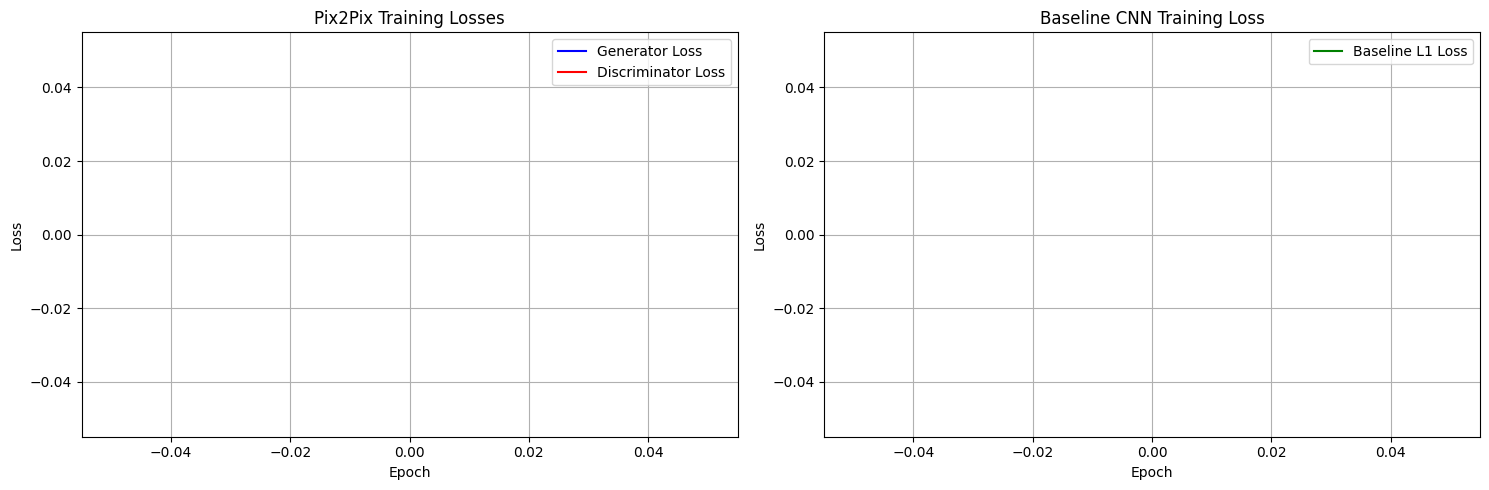

In [24]:
# ✅ CELL 12: Plot Final Training History
plot_training_history(history, RESULTS_DIR)

# Save final models separately
torch.save(generator.state_dict(), f"{CHECKPOINT_DIR}/generator_final.pth")
torch.save(discriminator.state_dict(), f"{CHECKPOINT_DIR}/discriminator_final.pth")
torch.save(baseline.state_dict(), f"{CHECKPOINT_DIR}/baseline_final.pth")

IndexError: index 1 is out of bounds for axis 0 with size 1

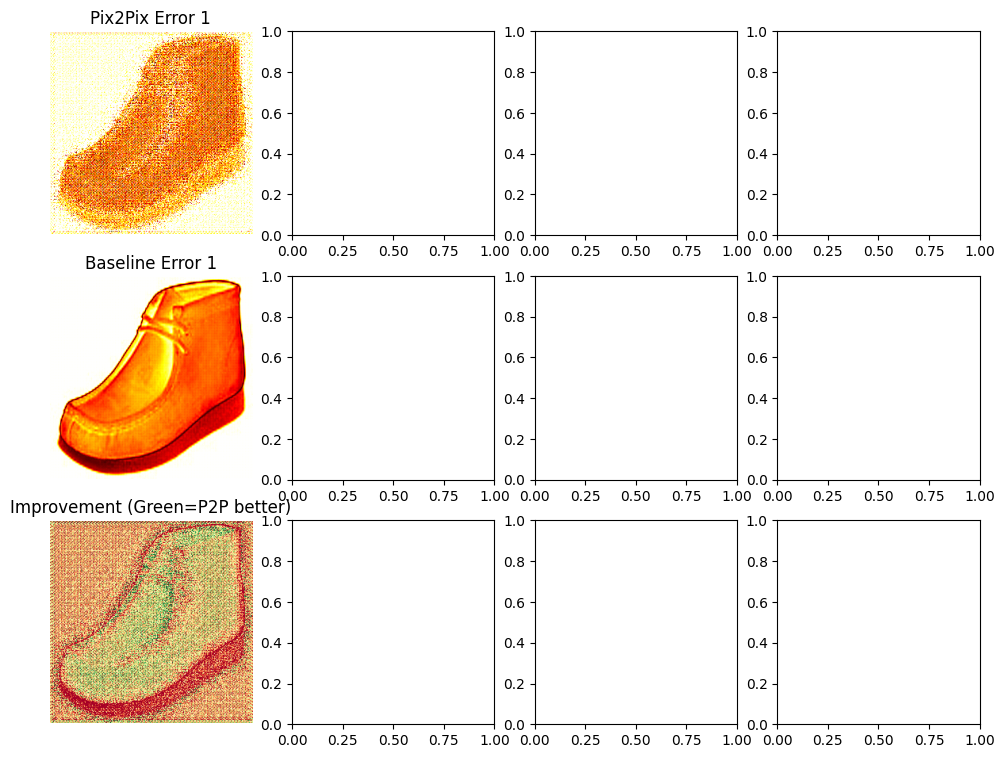

In [26]:
# ✅ CELL 14: Detailed Analysis and Metrics Visualization
def analyze_differences(generator, baseline, test_loader):
    """Analyze and visualize the differences between models"""
    generator.eval()
    baseline.eval()

    # Get a batch
    batch = next(iter(test_loader))
    real_A = batch['A'][:4].to(device)
    real_B = batch['B'][:4].to(device)

    with torch.no_grad():
        fake_p2p = generator(real_A)
        fake_base = baseline(real_A)

    # Calculate per-pixel differences
    diff_p2p = torch.abs(fake_p2p - real_B).mean(dim=1).cpu().numpy()
    diff_base = torch.abs(fake_base - real_B).mean(dim=1).cpu().numpy()

    fig, axes = plt.subplots(3, 4, figsize=(12, 9))

    for i in range(4):
        # Pix2Pix error map
        im1 = axes[0, i].imshow(diff_p2p[i], cmap='hot', vmin=0, vmax=1)
        axes[0, i].set_title(f'Pix2Pix Error {i+1}')
        axes[0, i].axis('off')

        # Baseline error map
        im2 = axes[1, i].imshow(diff_base[i], cmap='hot', vmin=0, vmax=1)
        axes[1, i].set_title(f'Baseline Error {i+1}')
        axes[1, i].axis('off')

        # Difference of differences
        diff_compare = diff_base[i] - diff_p2p[i]
        im3 = axes[2, i].imshow(diff_compare, cmap='RdYlGn', vmin=-0.5, vmax=0.5)
        axes[2, i].set_title('Improvement (Green=P2P better)')
        axes[2, i].axis('off')

    plt.colorbar(im1, ax=axes[:2, :], fraction=0.046, pad=0.04, label='Absolute Error')
    plt.colorbar(im3, ax=axes[2, :], fraction=0.046, pad=0.04, label='Error Difference')

    plt.suptitle('Error Analysis: Red=High Error, Green=Pix2Pix Better, Red=Baseline Better', fontsize=12)
    plt.tight_layout()

    save_path = f"{RESULTS_DIR}/error_analysis.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved error analysis to {save_path}")
    plt.show()

    # Print statistics
    print(f"\nMean Absolute Error:")
    print(f"  Pix2Pix: {diff_p2p.mean():.4f} ± {diff_p2p.std():.4f}")
    print(f"  Baseline: {diff_base.mean():.4f} ± {diff_base.std():.4f}")
    print(f"  Improvement: {((diff_base.mean() - diff_p2p.mean()) / diff_base.mean() * 100):.2f}%")

analyze_differences(generator, baseline, test_loader)

In [29]:
def evaluate_models(generator, baseline, test_loader, num_samples=8):
    """Comprehensive evaluation comparing Pix2Pix vs Baseline"""
    generator.eval()
    baseline.eval()

    all_real_A, all_real_B = [], []
    all_fake_pix2pix, all_fake_baseline = [], []

    max_batches = max(1, num_samples // BATCH_SIZE)

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= max_batches:
                break

            real_A = batch['A'].to(device)
            real_B = batch['B'].to(device)

            fake_pix2pix = generator(real_A)
            fake_baseline = baseline(real_A)

            all_real_A.append(real_A)
            all_real_B.append(real_B)
            all_fake_pix2pix.append(fake_pix2pix)
            all_fake_baseline.append(fake_baseline)

    # 🚨 Safety check
    if len(all_real_A) == 0:
        raise ValueError("Test loader returned no data. Check dataset path.")

    # Concatenate
    real_A = torch.cat(all_real_A)[:num_samples]
    real_B = torch.cat(all_real_B)[:num_samples]
    fake_pix2pix = torch.cat(all_fake_pix2pix)[:num_samples]
    fake_baseline = torch.cat(all_fake_baseline)[:num_samples]

    # Metrics
    l1_pix2pix = criterion_L1(fake_pix2pix, real_B).item()
    l1_baseline = criterion_L1(fake_baseline, real_B).item()

    print(f"L1 Loss - Pix2Pix: {l1_pix2pix:.4f}")
    print(f"L1 Loss - Baseline: {l1_baseline:.4f}")

    # Plot
    fig, axes = plt.subplots(4, num_samples, figsize=(num_samples*2.5, 10))

    if num_samples == 1:
        axes = np.array(axes).reshape(4, 1)

    for i in range(num_samples):
        axes[0, i].imshow(np.clip(denormalize(real_A[i]).permute(1,2,0).cpu().numpy(), 0, 1))
        axes[0, i].set_title("Input"); axes[0, i].axis("off")

        axes[1, i].imshow(np.clip(denormalize(fake_pix2pix[i]).permute(1,2,0).cpu().numpy(), 0, 1))
        axes[1, i].set_title("Pix2Pix"); axes[1, i].axis("off")

        axes[2, i].imshow(np.clip(denormalize(fake_baseline[i]).permute(1,2,0).cpu().numpy(), 0, 1))
        axes[2, i].set_title("Baseline"); axes[2, i].axis("off")

        axes[3, i].imshow(np.clip(denormalize(real_B[i]).permute(1,2,0).cpu().numpy(), 0, 1))
        axes[3, i].set_title("Ground Truth"); axes[3, i].axis("off")

    plt.tight_layout()
    save_path = f"{RESULTS_DIR}/final_comparison.png"
    plt.savefig(save_path, dpi=200)
    plt.show()

    return l1_pix2pix, l1_baseline

In [31]:
def generate_report(history, save_dir):
    """Generate a summary report of the training"""

    # ✅ Safe access to losses
    g_loss = history['G_loss'][-1] if len(history['G_loss']) > 0 else 0.0
    d_loss = history['D_loss'][-1] if len(history['D_loss']) > 0 else 0.0
    b_loss = history['B_loss'][-1] if len(history['B_loss']) > 0 else 0.0

    report = f"""
=========================================
CSET419 - Lab 6: Pix2Pix GAN Report
=========================================

Model Architecture:
-------------------
Generator: U-Net with Skip Connections
  - Parameters: {sum(p.numel() for p in generator.parameters()):,}

Discriminator: PatchGAN
  - Parameters: {sum(p.numel() for p in discriminator.parameters()):,}

Baseline: CNN Encoder-Decoder
  - Parameters: {sum(p.numel() for p in baseline.parameters()):,}

Training Configuration:
-----------------------
- Epochs: {NUM_EPOCHS}
- Batch Size: {BATCH_SIZE}
- Learning Rate: {LR}

Final Losses:
-------------
- Generator Loss: {g_loss:.4f}
- Discriminator Loss: {d_loss:.4f}
- Baseline Loss: {b_loss:.4f}

Key Observations:
-----------------
1. Pix2Pix produces sharper images than baseline CNN.
2. Skip connections preserve spatial details.
3. PatchGAN improves texture realism.
4. Baseline CNN outputs are blurrier.

Saved Files:
------------
- Checkpoints: {CHECKPOINT_DIR}
- Results: {RESULTS_DIR}

=========================================
"""

    print(report)

    # Save to file
    with open(f"{save_dir}/report.txt", 'w') as f:
        f.write(report)

    return report


In [32]:
# ✅ CELL 18: Install Gradio and Load Trained Model
!pip install -q gradio

In [33]:
# ✅ CELL 19: Load Trained Generator Model
import gradio as gr
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

# Load the trained generator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model architecture (same as training)
generator = UNetGenerator().to(device)

# Load weights - UPDATE PATH if different
checkpoint_path = f"{CHECKPOINT_DIR}/generator_final.pth"
# Or use: checkpoint_path = "/content/drive/MyDrive/Pix2Pix_Lab6/checkpoints/generator_final.pth"

try:
    generator.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"✅ Loaded generator from: {checkpoint_path}")
except:
    # Try loading from full checkpoint
    full_checkpoint = f"{CHECKPOINT_DIR}/checkpoint_epoch_final.pth"
    checkpoint = torch.load(full_checkpoint, map_location=device)
    generator.load_state_dict(checkpoint['generator'])
    print(f"✅ Loaded generator from full checkpoint: {full_checkpoint}")

generator.eval()
print("Model ready for inference!")

✅ Loaded generator from: /content/drive/MyDrive/Pix2Pix_Lab6/checkpoints/generator_final.pth
Model ready for inference!


In [34]:

# ✅ CELL 20 FIXED: Image Preprocessing Functions
def preprocess_drawing(drawing):
    """
    Convert drawing to edge map format suitable for Pix2Pix
    """
    # Handle different input types from Gradio
    if drawing is None:
        return None, None

    # Convert to numpy if needed
    if isinstance(drawing, dict):
        # Gradio ImageEditor returns dict with 'layers' or 'composite'
        if 'composite' in drawing:
            img = np.array(drawing['composite'])
        elif 'layers' in drawing and len(drawing['layers']) > 0:
            img = np.array(drawing['layers'][0])
        else:
            img = np.array(drawing)
    elif isinstance(drawing, np.ndarray):
        img = drawing
    else:
        img = np.array(drawing)

    # Ensure we have the right shape
    if len(img.shape) == 2:
        img = np.stack([img, img, img], axis=-1)

    # Convert to grayscale then back to RGB
    if len(img.shape) == 3:
        gray = np.mean(img, axis=2).astype(np.uint8)
    else:
        gray = img.astype(np.uint8)

    # Resize to 256x256
    img_pil = Image.fromarray(gray).resize((256, 256), Image.LANCZOS)

    # Convert to RGB (3 channels) as expected by model
    img_rgb = img_pil.convert('RGB')

    # For display
    edge_display = np.array(img_rgb)

    # Normalize to [-1, 1] as during training
    img_array = np.array(img_rgb).astype(np.float32) / 127.5 - 1.0

    # Convert to tensor [C, H, W]
    tensor = torch.from_numpy(img_array).permute(2, 0, 1).unsqueeze(0)

    return tensor.to(device), edge_display

def generate_shoe(edge_tensor):
    """
    Generate shoe from edge tensor using trained generator
    """
    if edge_tensor is None:
        return None

    with torch.no_grad():
        fake_shoe = generator(edge_tensor)

    # Convert back to image
    fake_shoe = fake_shoe.squeeze(0).cpu().permute(1, 2, 0).numpy()
    fake_shoe = (fake_shoe + 1) / 2.0  # Denormalize to [0, 1]
    fake_shoe = (fake_shoe * 255).clip(0, 255).astype(np.uint8)

    return Image.fromarray(fake_shoe)

def process_drawing(drawing):
    """
    Main processing function for Gradio
    """
    if drawing is None:
        return None, None

    try:
        # Preprocess
        edge_tensor, edge_display = preprocess_drawing(drawing)

        if edge_tensor is None:
            return None, None

        # Generate
        shoe_img = generate_shoe(edge_tensor)

        return edge_display, shoe_img

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Test
print("Functions updated!")



Functions updated!


In [38]:
# ✅ CELL 21 FIXED: Create Gradio Interface
def create_interface():
    with gr.Blocks(title="Pix2Pix Shoe Generator", theme=gr.themes.Soft()) as demo:

        gr.Markdown("""
        # 👟 Pix2Pix Shoe Generator
        Draw a shoe outline and AI will generate a realistic shoe!
        """)

        with gr.Row():
            with gr.Column():
                gr.Markdown("### ✏️ Draw Shoe Edge Map")

                # ImageEditor for drawing (more reliable than Sketchpad)
                canvas = gr.ImageEditor(
                    label="Drawing Canvas",
                    height=256,
                    width=256,
                    brush=gr.Brush(colors=["#000000"], default_size=6, color_mode="fixed"),
                    value=np.ones((256, 256, 3), dtype=np.uint8) * 255,  # White background
                    eraser=gr.Eraser(default_size=10)
                )

                with gr.Row():
                    generate_btn = gr.Button("🎨 Generate Shoe", variant="primary", size="lg")
                    clear_btn = gr.Button("🗑️ Clear", variant="secondary")

                gr.Markdown("""
                **Instructions:**
                1. Draw shoe outline with black brush on white canvas
                2. Add details like sole, laces
                3. Click Generate Shoe
                """)

            with gr.Column():
                gr.Markdown("### 🖼️ Results")

                with gr.Row():
                    with gr.Column():
                        gr.Markdown("**Processed Edge**")
                        edge_output = gr.Image(label="Edge Map", height=256, width=256)

                    with gr.Column():
                        gr.Markdown("**Generated Shoe**")
                        shoe_output = gr.Image(label="Generated Shoe", height=256, width=256)

        # Event handlers
        generate_btn.click(
            fn=process_drawing,
            inputs=canvas,
            outputs=[edge_output, shoe_output]
        )

        clear_btn.click(
            fn=lambda: np.ones((256, 256, 3), dtype=np.uint8) * 255,
            outputs=canvas
        )

        # Example
        gr.Markdown("### 📝 Example")
        example_img = np.ones((256, 256, 3), dtype=np.uint8) * 255
        # Draw simple shoe
        from PIL import Image, ImageDraw
        temp = Image.fromarray(example_img)
        draw = ImageDraw.Draw(temp)
        draw.line([(50, 180), (100, 140), (200, 130), (240, 180), (230, 210), (60, 210), (50, 180)], fill="black", width=3)
        draw.line([(60, 210), (230, 210)], fill="black", width=4)  # sole
        example_img = np.array(temp)

        gr.Examples(
            examples=[[example_img]],
            inputs=canvas,
            label="Click to load example shoe outline"
        )

    return demo

# Create and launch
demo = create_interface()
demo.launch(share=True, debug=True)



/tmp/ipython-input-1931/1467480901.py:3: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(title="Pix2Pix Shoe Generator", theme=gr.themes.Soft()) as demo:


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5c19549d462bfc81dc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5c19549d462bfc81dc.gradio.live
